# Part 4: Powering Up Our Model
In this notebook we'll look at the concept of cross validation, and we'll explore some non-linear models to capture deeper relationships in our data.

## Cross Validation
In part 3 we tested our balanced linear regression model and got an F1 score of 0.156, but when we submitted we got a much worse score.

One reason for this is that we tested our model on data that it had already seen (the training data). This is a little your teacher giving you the questions on the test before the test--sure you still have to memorize the answers, but that's a lot easier than having to answer questions you've never seen before.

To measure how well our model will perform on data it hasn't seen yet, one strategy we can use is cross validation.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score

train_df = pd.read_csv('/kaggle/input/global-hack-week-detect-credit-card-fraud/train.csv')
train_df.head()

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,16979,3.346870,0.620101,0.945172,1.0,0.0,0.0,1.0,0
1,12430,14.482868,0.170185,1.084836,1.0,0.0,0.0,1.0,0
2,19872,5.740898,0.167525,3.969652,1.0,0.0,0.0,1.0,0
3,18763,4.098570,0.291850,0.084129,1.0,1.0,0.0,1.0,1
4,13547,7.539580,0.294439,2.890880,1.0,1.0,0.0,0.0,0


In [2]:
from sklearn.model_selection import train_test_split

val_train_df, val_test_df = train_test_split(train_df, random_state=12)

In [3]:
# Our validation training set has 13500 rows, and our validation test df has 4500 rows
print(len(val_train_df))
print(len(val_test_df))

13500
4500


In [4]:
# Now we can build a model and only train it on our cross validation training set

input_columns = train_df.columns[1:-1]

model = LogisticRegression(class_weight='balanced')
model = model.fit(val_train_df[input_columns], val_train_df['fraud'])

In [5]:
# Now instead of testing it on the same data it was trained on,
# we can test in on the validation test set:
validation_predictions = model.predict(val_test_df[input_columns])
fbeta_score(validation_predictions, val_test_df['fraud'], beta=0.5)

0.2415143603133159

In [6]:
# Great! This number is lower, but it's probably a more realistic estimate of our how model
# will do on new data.

## Decision Trees
One problem with logistic regression is that it can only capture linear relationships.
For example, in our dataset each value can only mean "more likely it's fraud" or "less likely it's fraud".

But what if `ratio_to_median_purchase_price` only means "more likely it's fraud" _if_ `repeat_retailer` is false (i.e. the card holder has never shopped there before)? A logistic regression model couldn't capture this relationship.

One kind of _non linear_ is called a decision tree. You can think of it kind of like a flow chart of questions. Depending on the answer to the first question, it will ask different followup questions, creating a branching "tree" until it has enough information to guess what the label should be.

This kind of model is great at handling those cases like `ratio_to_median_purchase_price` only means "more likely it's fraud" _if_ `repeat_retailer` is false. So lets give that a shot!


In [7]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced')
decision_tree = decision_tree.fit(val_train_df[input_columns], val_train_df['fraud'])

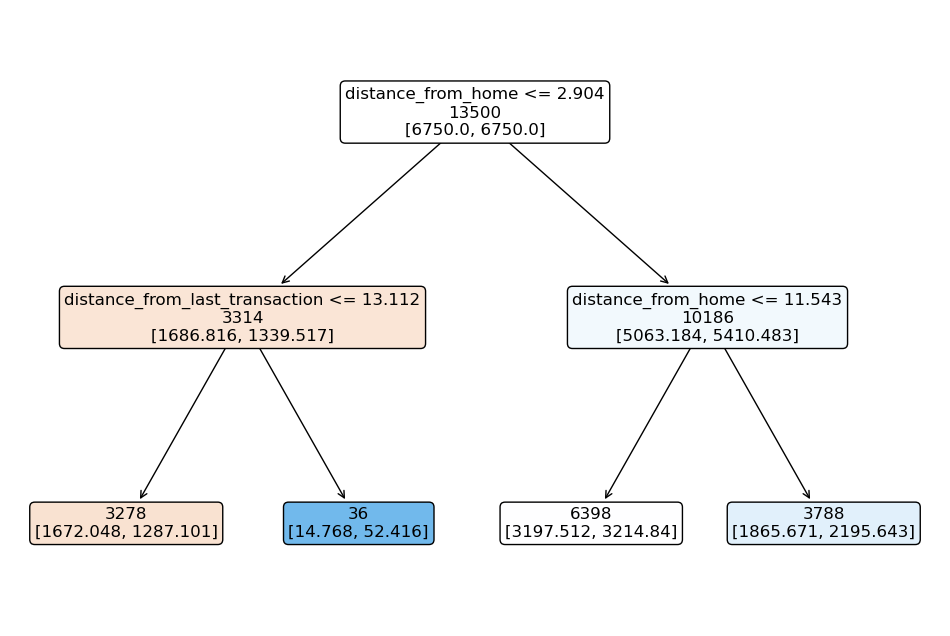

In [8]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
tree.plot_tree(decision_tree, rounded=True, impurity=False, filled=True, label=None, feature_names=input_columns, fontsize=12, max_depth=2)
plt.show()

In [9]:
decision_tree_predictions = decision_tree.predict(val_test_df[input_columns])
fbeta_score(decision_tree_predictions, val_test_df['fraud'], beta=0.5)


0.29174237835655165

In [10]:
scores = []
depths = list(range(1,20))
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth, class_weight='balanced')
    decision_tree = decision_tree.fit(val_train_df[input_columns], val_train_df['fraud'])
    # decision_tree_predictions = decision_tree.predict(val_test_df[input_columns])
    # score = fbeta_score(decision_tree_predictions, val_test_df['fraud'], beta=0.5)
    decision_tree_predictions = decision_tree.predict(val_train_df[input_columns])
    score = fbeta_score(decision_tree_predictions, val_train_df['fraud'], beta=0.5)
    scores.append(score)

Text(0.5, 1.0, 'Is a bigger tree always better?')

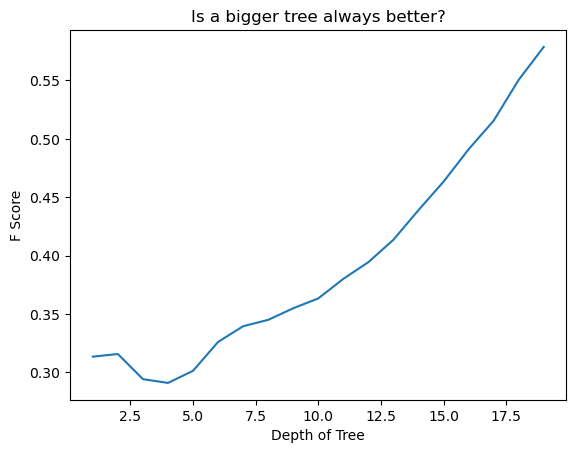

In [11]:
plt.plot(depths, scores)
plt.xlabel('Depth of Tree')
plt.ylabel('F Score')
plt.title('Is a bigger tree always better?')

Text(0.5, 1.0, 'Is a bigger tree always better?')

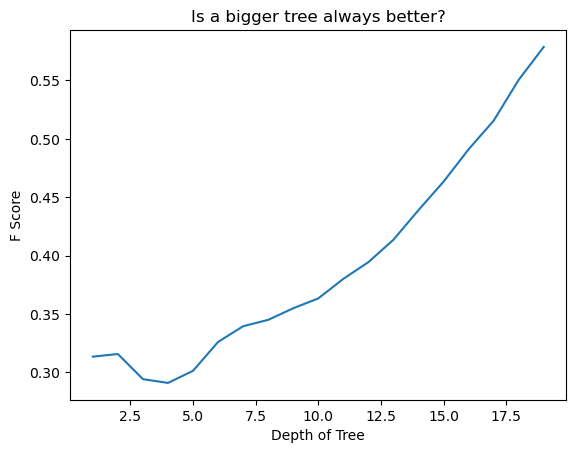

In [12]:
plt.plot(depths, scores)
plt.xlabel('Depth of Tree')
plt.ylabel('F Score')
plt.title('Is a bigger tree always better?')

In [13]:
# It looks like distance_from_home is a really important feature!
# But our model also know that if the distance is far (> 29 miles)
# the amount the purchase was for also matters (captured in ratio_to_median_purchase_price)

## Random Forests
By looking into our decision tree we can see that it specifically asks a lot of questions about distance.
One way we could think of this is that our model has become an expert in the nuances of `distance_from_home`.

One way we can power up our predictions is by creating several models that are all experts
in different things, and letting them all vote on the answer. This strategy is called "ensembling"
(because we end up with an ensemble of models).

We can also experiment with manually setting our class weights: instead of just asking our model to balance them,
we can tell the model to weight each instance of fraud as 500x more important than each normal transaction

In [14]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(
    n_estimators=50,
    max_depth=2,
    class_weight={1: 100, 0: 1})

random_forest = random_forest.fit(val_train_df[input_columns], val_train_df['fraud'])

In [15]:
random_forest_predictions = random_forest.predict(val_test_df[input_columns])
fbeta_score(random_forest_predictions, val_test_df['fraud'], beta=0.4)

0.4068890892696123

In [16]:
forest_sizes = range(10,200,10)
scores = []

for forest_size in forest_sizes:
    random_forest = RandomForestClassifier(
        n_estimators=forest_size,
        max_depth=3,
        class_weight={1: 100, 0: 1})

    random_forest = random_forest.fit(val_train_df[input_columns], val_train_df['fraud'])
    random_forest_predictions = random_forest.predict(val_test_df[input_columns])
    score = fbeta_score(random_forest_predictions, val_test_df['fraud'], beta=0.5)
    scores.append(score)

Text(0.5, 1.0, 'Is a bigger forest always better?')

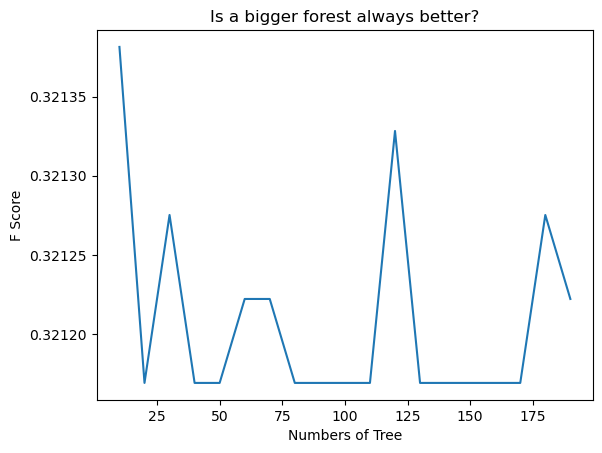

In [17]:
plt.plot(forest_sizes, scores)
plt.xlabel('Numbers of Tree')
plt.ylabel('F Score')
plt.title('Is a bigger forest always better?')

In [18]:
# That's looking a little better!
# Lets use our RandomForest to generate some test predictions and submit them!

test_df = pd.read_csv('/kaggle/input/global-hack-week-detect-credit-card-fraud/test.csv')
test_df.head()

,id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,12367,2.067482,0.064300,1.472587,1.0,0.0,0.0,1.0
1,10942,9.078248,0.058169,1.494500,1.0,0.0,0.0,1.0
2,12171,2.156680,0.343030,0.419576,1.0,0.0,0.0,1.0
3,17800,3.087393,0.424519,0.879299,1.0,0.0,0.0,0.0
4,14230,14.162849,0.072577,1.262928,1.0,0.0,0.0,0.0


In [19]:
predictions = random_forest.predict(test_df[input_columns])
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
submission_df = test_df.copy()
submission_df['fraud'] = predictions.astype(int)
submission_df[['id', 'fraud']].to_csv('submission.csv', index=False)